In [9]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from sklearn.preprocessing import LabelEncoder

In [10]:
path_labels = ['PNEUMONIA', 'NORMAL']
labels = ['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in path_labels: 
        path = os.path.join(data_dir, label)
        #class_num = labels.index(label)
        
        for img in os.listdir(path):
            if "bacteria" in img:
                class_num = 0 # 0 is the bacteria pneumonia class
            elif "virus" in img:
                class_num = 2  
            else:
                class_num = 1 # 1 is normal class, like in other model


            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
    return data

In [11]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

In [12]:
print(len(train))
print(len(test))
print(len(val))
# Validation is only 16 images. 

5216
624
16


In [13]:
virus_count = 0
bacteria_count = 0
normal_count = 0

for image in train:
    if image[1] == 0: # bacteria
        bacteria_count += 1
    elif image[1] == 1: # normal
        normal_count += 1
    else:
        virus_count += 1 # virus

print("Virus Cases: ", virus_count)
print("Bacteria Count", bacteria_count)
print("Normal Cases: ", normal_count)

Virus Cases:  1345
Bacteria Count 2530
Normal Cases:  1341


Text(0.5, 1.0, 'VIRAL PNEUMONIA')

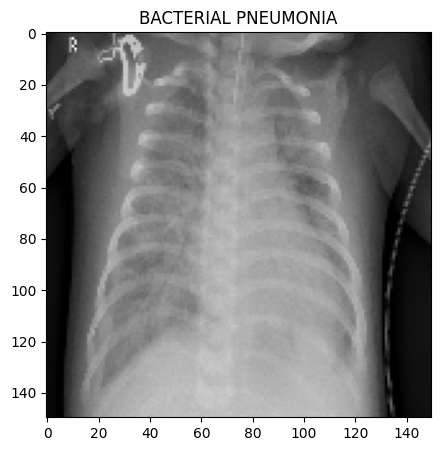

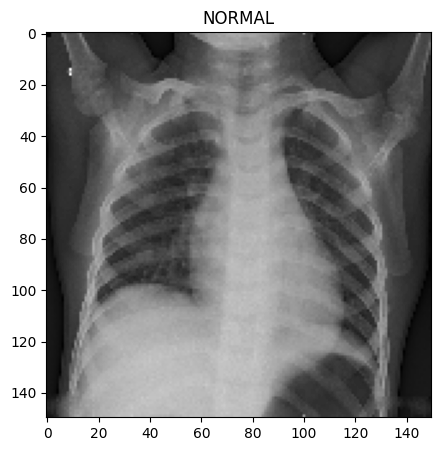

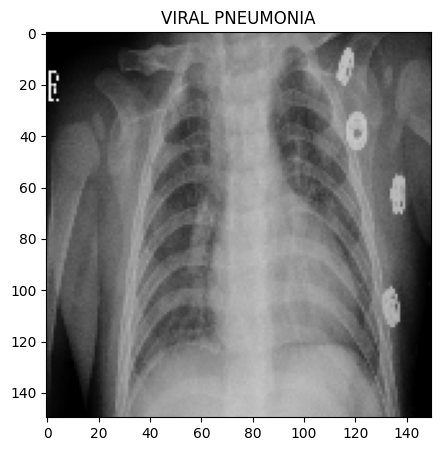

In [14]:
# Look at first training image
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

# Look at final training image
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

# Look at final training image
plt.figure(figsize = (5,5))
plt.imshow(train[180][0], cmap='gray')
plt.title(labels[train[180][1]])

In [15]:
x_train = []
y_train = []

x_test_A_B_val = []
y_test_A_B_val = []

for feature, label in train:
    x_train.append(feature)
    label_array = [0] * 3
    label_array[label] = 1
    y_train.append(label_array)

for feature, label in test:
    x_test_A_B_val.append(feature)
    label_array=[0] * 3
    label_array[label] = 1
    y_test_A_B_val.append(label_array)
    
random_sample = 100

x_val, x_test, y_val, y_test   = train_test_split(x_test_A_B_val, y_test_A_B_val, test_size=0.8, random_state=random_sample)
x_test_A,   x_test_B,   y_test_A,   y_test_B     = train_test_split(x_test, y_test, test_size=0.7, random_state=random_sample)





In [16]:
print(len(x_train))
print(len(x_val))
print(len(x_test_A))
print(len(x_test_B))
print(x_train[0].shape)

5216
124
150
350
(150, 150)


In [17]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test_A = np.array(x_test_A) / 255
x_test_B = np.array(x_test_B) / 255

In [18]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test_A = x_test_A.reshape(-1, img_size, img_size, 1)
y_test_A = np.array(y_test_A)

x_test_B = x_test_B.reshape(-1, img_size, img_size, 1)
y_test_B = np.array(y_test_B)

In [19]:
for dataset, dataset_name in zip([y_train,y_val,y_test_A,y_test_B],["y_train","y_val","y_test_A","y_test_B"]):
    virus_count = 0
    bacteria_count = 0
    normal_count = 0
    for label in dataset:
        if label[0] == 1: # bacteria
            bacteria_count += 1
        elif label[1] == 1: # normal
            normal_count += 1
        else:
            virus_count += 1
    
    print(f"\n{dataset_name}")
    print("Virus Cases: ", virus_count)
    print("Bacteria Count", bacteria_count)
    print("Normal Cases: ", normal_count)


y_train
Virus Cases:  1345
Bacteria Count 2530
Normal Cases:  1341

y_val
Virus Cases:  32
Bacteria Count 48
Normal Cases:  44

y_test_A
Virus Cases:  36
Bacteria Count 63
Normal Cases:  51

y_test_B
Virus Cases:  80
Bacteria Count 131
Normal Cases:  139


In [20]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='multiclass_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"multiclass_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [22]:
history = model.fit(x_train,y_train, batch_size = 32, epochs = 30 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
163/163 [==============================] - 78s 471ms/step - loss: 0.6159 - accuracy: 0.6865 - val_loss: 1.0119 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 76s 469ms/step - loss: 0.3438 - accuracy: 0.7699 - val_loss: 0.8619 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 80s 490ms/step - loss: 0.3115 - accuracy: 0.7803 - val_loss: 0.9684 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 84s 512ms/step - loss: 0.2964 - accuracy: 0.7922 - val_loss: 0.5941 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 77s 473ms/step - loss: 0.2798 - accuracy: 0.8066 - val_loss: 1.2371 - val_accuracy: 0.5565 - lr: 0.0010
Epoch 6/30
163/163 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8221
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 82s 506ms/step - loss: 0.2699 - accuracy: 0.8221 - val_loss: 1.1640 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 7/30
163/163 [==============================] - 82s 50

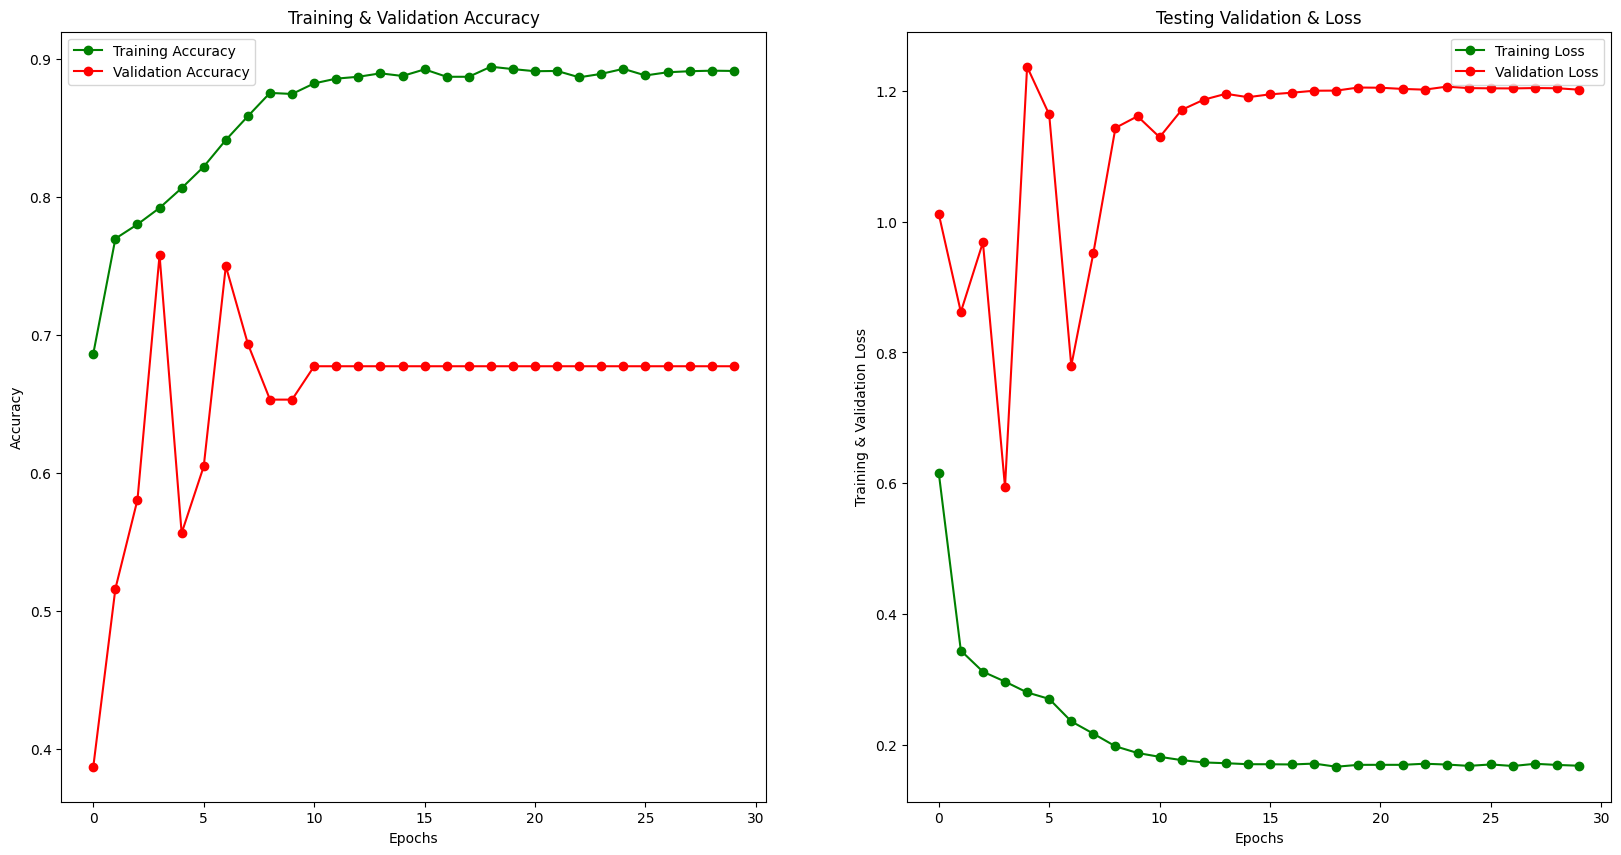

In [23]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [24]:
best_model = keras.models.load_model("multiclass_models/best_model_epoch_04.h5")

In [25]:
results_A = best_model.evaluate(x_test_A,y_test_A)
results_B = best_model.evaluate(x_test_B,y_test_B)
print("test loss A, test acc A:", results_A)
print("test loss B, test acc B:", results_B)

11/11 [==============================] - 1s 86ms/step - loss: 0.5271 - accuracy: 0.7429
test loss A, test acc A: [0.42615222930908203, 0.8266666531562805]
test loss B, test acc B: [0.5271427035331726, 0.7428571581840515]


In [55]:
predictions_A = model.predict(x_test_A)
predictions_B = model.predict(x_test_B)
predictions_A = [np.argmax(p) for p in predictions_A]
predictions_B = [np.argmax(p) for p in predictions_B]

11/11 [==============================] - 1s 83ms/step


In [66]:
print("Test Set A")
print(classification_report([np.argmax(l) for l in y_test_A], predictions_A, target_names =['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']))
print("\nTest Set B")
print(classification_report([np.argmax(l) for l in y_test_B], predictions_B, target_names =['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']))

print("Test Set A")
print(confusion_matrix([np.argmax(l) for l in y_test_A], predictions_A))
print("\nTest Set B")
print(confusion_matrix([np.argmax(l) for l in y_test_B],predictions_B))


Test Set A
                     precision    recall  f1-score   support

BACTERIAL PNEUMONIA       0.77      0.95      0.85        63
             NORMAL       0.95      0.35      0.51        51
    VIRAL PNEUMONIA       0.58      0.86      0.70        36

           accuracy                           0.73       150
          macro avg       0.77      0.72      0.69       150
       weighted avg       0.79      0.73      0.70       150


Test Set B
                     precision    recall  f1-score   support

BACTERIAL PNEUMONIA       0.71      0.96      0.82       131
             NORMAL       1.00      0.35      0.51       139
    VIRAL PNEUMONIA       0.45      0.70      0.55        80

           accuracy                           0.66       350
          macro avg       0.72      0.67      0.63       350
       weighted avg       0.77      0.66      0.63       350

Test Set A
[[60  1  2]
 [13 18 20]
 [ 5  0 31]]

Test Set B
[[126   0   5]
 [ 27  48  64]
 [ 24   0  56]]
